# Data 102 Final Project, Fall 2024

In [30]:
%%capture
#NOTE: Setup will need python installation along with all the libraries below
# this can all be done by running the code below
#if you want to see error messages, comment out the capture above ^^^

#download libraries
!python.exe -m pip install --upgrade pip -q
%pip install pandas -q 
%pip install matplotlib -q
%pip install seaborn -q
%pip install numpy -q

## 2.1 Data Overview

In [31]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pymc as pm
import bambi as bmb
import arviz as az
import statsmodels.api as sm

import sklearn.metrics as metrics

dem = pd.read_csv("dem_candidates.csv", encoding='latin-1')
rep = pd.read_csv("rep_candidates.csv", encoding='latin-1')
candidate_2018 = pd.read_csv('candidate_summary_2018.csv', encoding = 'latin-1')
rep_labeled = rep.copy()
rep_labeled['Party'] = 'Republican'
dem_labeled = dem.copy()
dem_labeled['Party'] = 'Democrat'
all_parties = pd.concat([rep_labeled, dem_labeled])
all_parties['Individual Endorsement'] = all_parties[['Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?', 
    'Trump Endorsed?', 'Bannon Endorsed?', 'Susan B. Anthony Endorsed?']].any(axis=1)
all_parties['Group Endorsement'] = all_parties[['Great America Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?',
        'Club for Growth Endorsed?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?', 
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?']].any(axis=1)
all_parties['Endorsement'] = all_parties[['Great America Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?',
        'Club for Growth Endorsed?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?', 
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?', 'Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?', 
    'Trump Endorsed?', 'Bannon Endorsed?', 'Susan B. Anthony Endorsed?']].any(axis=1)
endorsement_count = all_parties.groupby('Candidate')['Endorsement'].sum().reset_index()
endorsement_count_primary = all_parties.groupby('Candidate')['Primary %'].mean().reset_index()
endorsement_count_eda = pd.concat([endorsement_count, endorsement_count_primary], axis = 1)
endorsement_count_eda = endorsement_count_eda.loc[:,~endorsement_count_eda.columns.duplicated()]
all_parties = all_parties.merge(endorsement_count_eda[['Candidate', 'Endorsement']], on='Candidate', how='left')
all_parties.rename(columns={'Endorsement_x': 'Endorsement'}, inplace=True)
all_parties.rename(columns={'Endorsement_y': 'Endorsement Count'}, inplace=True)

In [32]:
endorsement_count_eda.head()

,Candidate,Endorsement,Primary %
0,A.J. Balukoff,1,40.099998
1,Aaron Godfrey,1,7.910000
2,Aaron Pettigrew,1,15.500000
3,Aaron Scheinberg,1,37.430000
4,Aaron Swisher,0,67.599998


In [33]:
dem.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
rep.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Primary %,...,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?
0,Mike Dunleavy,AK,Governor of Alaska,Governor,Regular,8/21/18,Advanced,NaN,On the Ballot,61.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Michael Sheldon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mead Treadwell,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,31.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Darin Colbry,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thomas Gordon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
all_parties.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Primary %,...,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,Individual Endorsement,Group Endorsement,Endorsement,Endorsement Count
0,Mike Dunleavy,AK,Governor of Alaska,Governor,Regular,8/21/18,Advanced,NaN,On the Ballot,61.8,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,0
1,Michael Sheldon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,0
2,Mead Treadwell,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,31.9,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,0
3,Darin Colbry,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,0
4,Thomas Gordon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,0


In [36]:
candidate_2018.head()

,Link_Image,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Cand_Party_Affiliation,Cand_Incumbent_Challenger_Open_Seat,Total_Receipt,Total_Disbursement,...,Individual_Refund,Party_Committee_Refund,Other_Committee_Refund,Total_Contribution_Refund,Other_Disbursements,Net_Contribution,Net_Operating_Expenditure,Cash_On_Hand_BOP,Debt_Owe_To_Committee,Coverage_Start_Date
0,https://www.fec.gov/data/candidate/H8TX05052/?...,"ASHBY, KEN",H8TX05052,H,TX,4.0,LIB,CHALLENGER,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
1,https://www.fec.gov/data/candidate/S6OH00288/?...,"ECKHART, DON ELIJAH",S6OH00288,S,OH,0.0,REP,CHALLENGER,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
2,https://www.fec.gov/data/candidate/S8CA00499/?...,"ZIESING, MICHAEL VINCENT",S8CA00499,S,CA,0.0,GRE,CHALLENGER,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
3,https://www.fec.gov/data/candidate/H6NJ13191/?...,"SIRES, ALBIO",H6NJ13191,H,NJ,8.0,DEM,INCUMBENT,460108.57,596546.56,...,0.0,0.0,500.0,500.0,98504.05,459357.05,437542.51,290287.08,0.0,01/01/2017
4,https://www.fec.gov/data/candidate/H6MI03172/?...,"SMITH, DOUGLAS MARK MR. JR.",H6MI03172,H,MI,3.0,IND,CHALLENGER,0.00,3873.60,...,0.0,0.0,0.0,0.0,0.00,0.00,3873.60,3873.60,0.0,01/01/2017


## 2.4 EDA

Text(0.5, 1.0, 'Effects of Being Previously Elected on Winning Primary Election for Democrats')

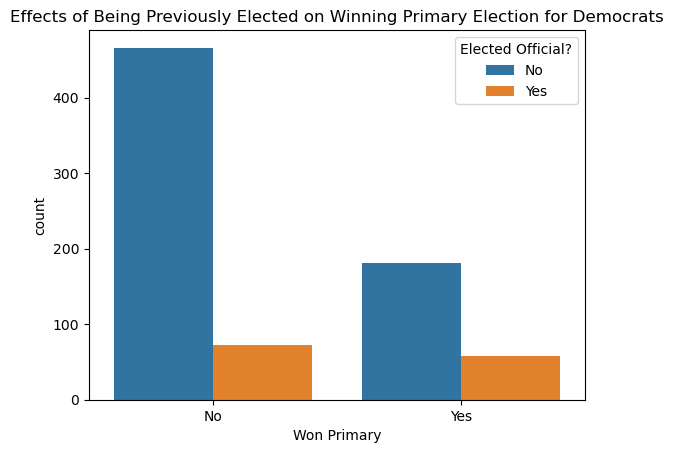

In [39]:
#relationship between Elected Official? and Won Primary 
sns.countplot(data = dem, x = 'Won Primary', hue = 'Elected Official?')
plt.title('Effects of Being Previously Elected on Winning Primary Election for Democrats')

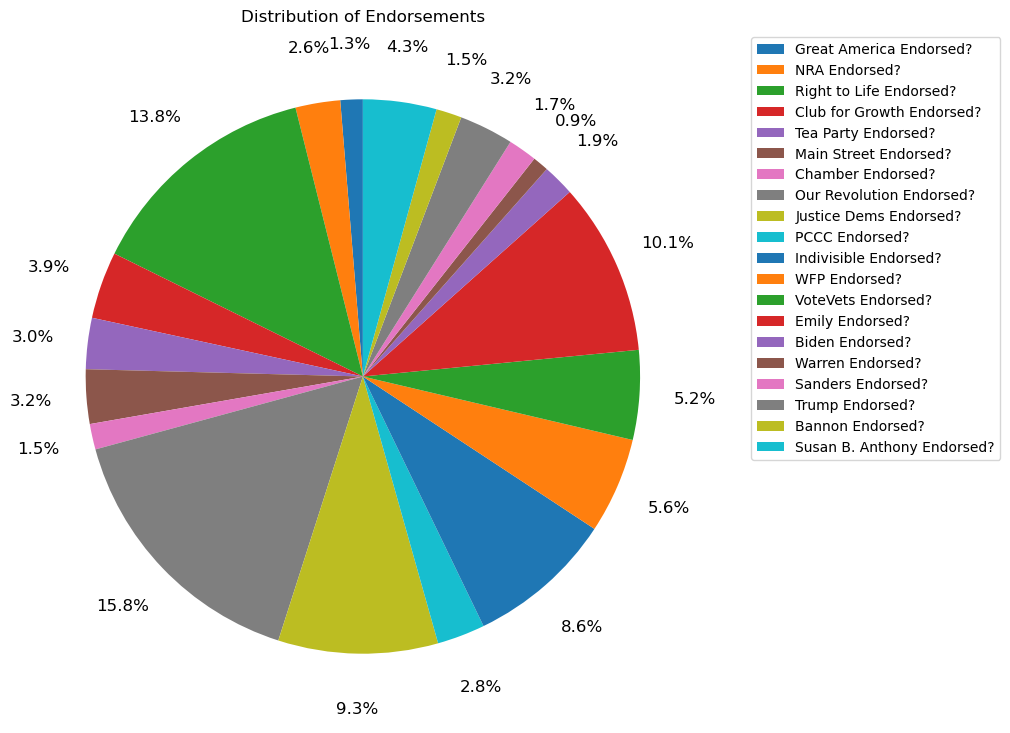

In [41]:
endorsement_columns = [
    "Great America Endorsed?", "NRA Endorsed?", "Right to Life Endorsed?", 
    "Club for Growth Endorsed?", "Tea Party Endorsed?", "Main Street Endorsed?", 
    "Chamber Endorsed?", "Our Revolution Endorsed?", "Justice Dems Endorsed?", 
    "PCCC Endorsed?", "Indivisible Endorsed?", "WFP Endorsed?", 
    "VoteVets Endorsed?", "Emily Endorsed?", "Biden Endorsed?", 
    "Warren Endorsed? ", "Sanders Endorsed?", "Trump Endorsed?", 
    "Bannon Endorsed?", "Susan B. Anthony Endorsed?"
]

endorsement_counts = all_parties[endorsement_columns].apply(lambda col: col.str.count("Yes").sum())
endorsement_counts = endorsement_counts[endorsement_counts > 0]
plt.figure(figsize=(15,9))
plt.pie(endorsement_counts, pctdistance=1.2, autopct='%1.1f%%', startangle=90, textprops={'fontsize':12}, labeldistance=0.1)
plt.legend(endorsement_columns, bbox_to_anchor=(1.05,1), loc='upper left')
plt.title("Distribution of Endorsements")
plt.show()

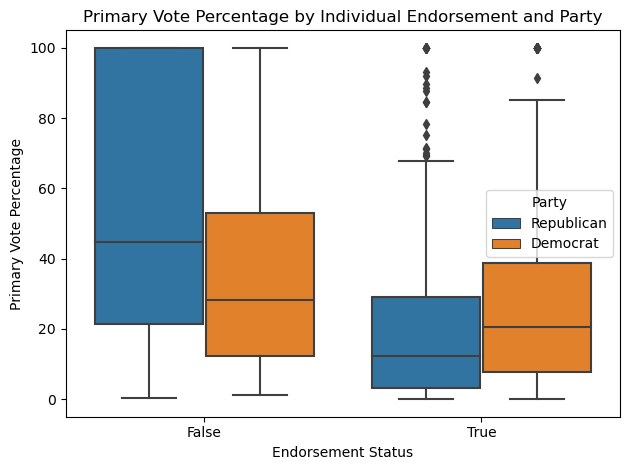

In [42]:
# Republican vs Democrat differences in Primary % with or without endorsement(categorial)

sns.boxplot(
    data=all_parties.reset_index(),
    x='Endorsement',
    y='Primary %',
    hue='Party'
)

plt.title("Primary Vote Percentage by Individual Endorsement and Party")
plt.xlabel("Endorsement Status")
plt.ylabel("Primary Vote Percentage")
plt.legend(title="Party")
plt.tight_layout()
plt.show()

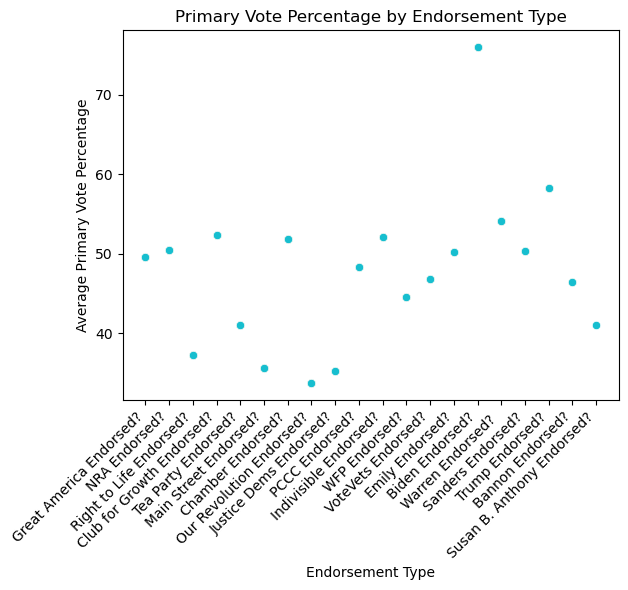

In [46]:
# scatter plot for each endorsement type (quantitative)

endorsement_types = ['Great America Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?',
        'Club for Growth Endorsed?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?', 
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?', 'Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?', 
    'Trump Endorsed?', 'Bannon Endorsed?', 'Susan B. Anthony Endorsed?']
all_endorsements = pd.DataFrame()
all_primary_percentage = pd.DataFrame()
all_primary_percentage['Endorsement Type'] = endorsement_types
all_primary_percentage['Primary %'] = None

for endorsement_type in endorsement_types:
    endorsement_mean = all_parties.groupby(endorsement_type)['Primary %'].mean().reset_index()['Primary %'][1]
    all_primary_percentage.loc[all_primary_percentage['Endorsement Type'] == endorsement_type, 'Primary %'] = endorsement_mean

    sns.scatterplot(
        data=all_primary_percentage,
        x='Endorsement Type',
        y='Primary %'
    )

plt.title("Primary Vote Percentage by Endorsement Type")
plt.xlabel("Endorsement Type")
plt.ylabel("Average Primary Vote Percentage")
plt.xticks(rotation=45, ha='right')
plt.gca().invert_yaxis()
plt.show()


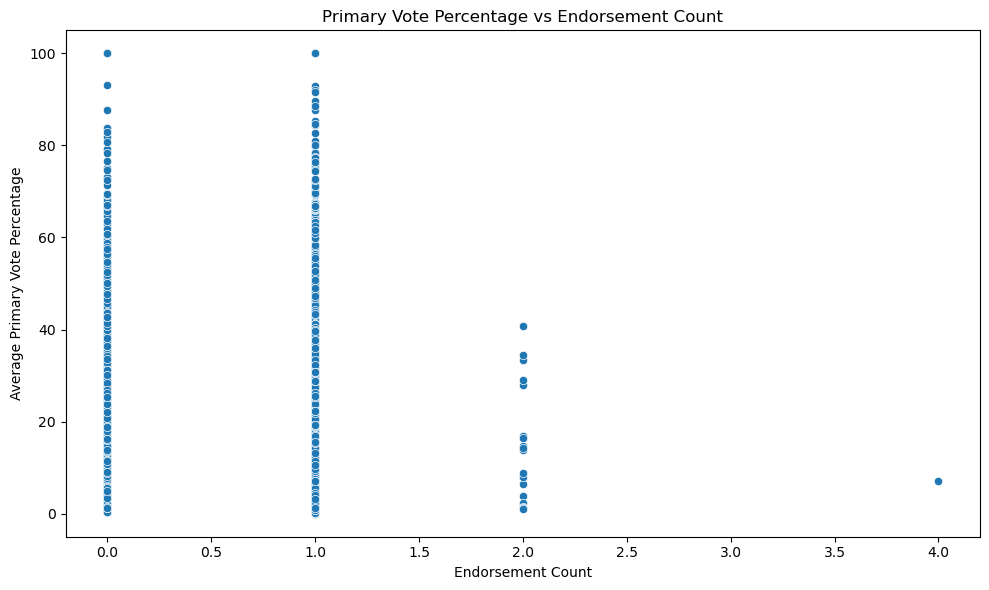

In [44]:
# if higher endorsements cause higher Primary % (quantitative)

endorsement_count_eda['Endorsement Count'] = endorsement_count_eda.groupby('Candidate')['Endorsement'].transform('sum')
average_primary_percentage = endorsement_count_eda.groupby('Candidate')['Primary %'].mean().reset_index()
merged_data = endorsement_count_eda[['Candidate', 'Endorsement Count']].drop_duplicates().merge(average_primary_percentage, on='Candidate')

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data,
    x='Endorsement Count',
    y='Primary %'
)

plt.title("Primary Vote Percentage vs Endorsement Count")
plt.xlabel("Endorsement Count")
plt.ylabel("Average Primary Vote Percentage")
plt.tight_layout()
plt.show()

## 2.7 Option C: Prediction with GLMs and nonparametric methods

#### How do different endorsements correlate with the total primary vote percentage? We want to predict the vote percentage and look at the correlation coefficients between endorsements and vote percentage.

In [13]:
# data cleaning
data = all_parties[endorsement_columns + ['Endorsement Count', 'Primary %']]
data.loc[:, endorsement_columns]= data[endorsement_columns].replace({'No': 0, 'Yes': 1}).fillna(0)
for col in endorsement_columns:
    data[col] = pd.to_numeric(data[col])
data = data.dropna(subset=['Primary %'])

/tmp/ipykernel_480/181694793.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col])


In [14]:
data.head(5)

,Great America Endorsed?,NRA Endorsed?,Right to Life Endorsed?,Club for Growth Endorsed?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,...,VoteVets Endorsed?,Emily Endorsed?,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Trump Endorsed?,Bannon Endorsed?,Susan B. Anthony Endorsed?,Endorsement Count,Primary %
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,61.8
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31.9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.3


In [15]:
# Train-Test Split
from sklearn.model_selection import train_test_split

features = endorsement_columns + ['Endorsement Count']
train, test = train_test_split(data, test_size=0.3, random_state=101)

In [16]:
# GLM Model
model = sm.GLM(train['Primary %'], exog=sm.add_constant(train[features]), family=sm.families.Gaussian())
results = model.fit()

train["glm_pred"] = results.predict(sm.add_constant(train[features]))
test["glm_pred"] = results.predict(sm.add_constant(test[features]))

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                 1101
Model:                            GLM   Df Residuals:                     1079
Model Family:                Gaussian   Df Model:                           21
Link Function:               Identity   Scale:                          694.78
Method:                          IRLS   Log-Likelihood:                -5153.4
Date:                Mon, 16 Dec 2024   Deviance:                   7.4967e+05
Time:                        03:52:49   Pearson chi2:                 7.50e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2512
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [17]:
# GLM Model Evaluation Metrics
glm_train_rmse = metrics.mean_squared_error(train['Primary %'], train["glm_pred"], squared=False)
glm_test_rmse = metrics.mean_squared_error(test['Primary %'], test["glm_pred"], squared=False)

glm_train_r2 = metrics.r2_score(train['Primary %'], train["glm_pred"])
glm_test_r2 = metrics.r2_score(test['Primary %'], test["glm_pred"])

print(f"GLM Training RMSE: {glm_train_rmse:.4f}")
print(f"GLM Test RMSE:     {glm_test_rmse:.4f}")
print(f"GLM Training R²:   {glm_train_r2:.4f}")
print(f"GLM Test R²:       {glm_test_r2:.4f}")
print(f"GLM AIC:           {results.aic:.4f}")

GLM Training RMSE: 26.0940
GLM Test RMSE:     25.5323
GLM Training R²:   0.2278
GLM Test R²:       0.2009
GLM AIC:           10350.7814


In [18]:
# Decision Tree Model
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(train[features], train['Primary %'])

train["tree_pred"] = tree_model.predict(train[features])
test["tree_pred"] = tree_model.predict(test[features])

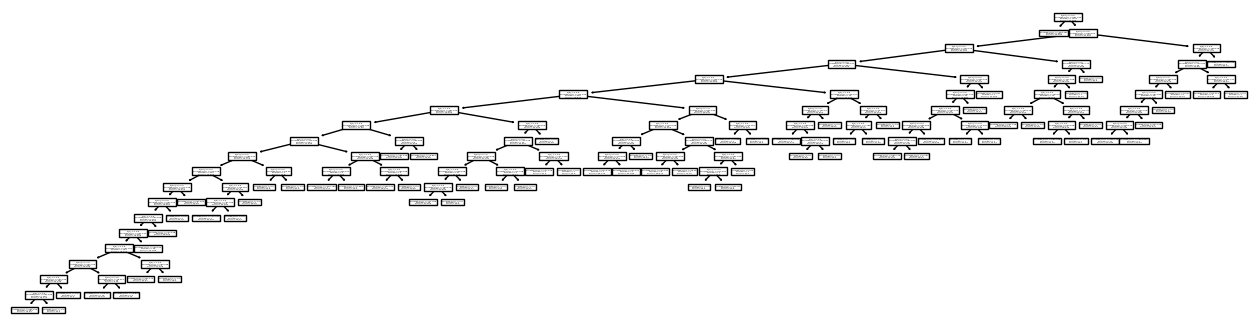

In [19]:
# Decision Tree Plot
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 4))
plot_tree(tree_model);

In [20]:
# Decision Tree Evaluation Metrics
tree_train_rmse = metrics.mean_squared_error(train['Primary %'], train["tree_pred"], squared=False)
tree_test_rmse = metrics.mean_squared_error(test['Primary %'], test["tree_pred"], squared=False)

tree_train_r2 = metrics.r2_score(train['Primary %'], train['tree_pred'])
tree_test_r2 = metrics.r2_score(test['Primary %'], test['tree_pred'])

tree_rss = np.sum((train["Primary %"] - train['tree_pred']) ** 2)
tree_aic = 2 * tree_model.get_n_leaves() + len(train) * np.log(tree_rss / len(train))

print(f"Decision Tree Training RMSE: {tree_train_rmse:.4f}")
print(f"Decision Tree Test RMSE:     {tree_test_rmse:.4f}")
print(f"Decision Tree Training R²:   {tree_train_r2:.4f}")
print(f"Decision Tree Test R²:       {tree_test_r2:.4f}")
print(f"Decision Tree AIC:           {tree_aic:.4f}")

Decision Tree Training RMSE: 24.8995
Decision Tree Test RMSE:     25.6172
Decision Tree Training R²:   0.2969
Decision Tree Test R²:       0.1955
Decision Tree AIC:           7219.0981


## 2.8 Option D: Causal Inference

#### Does being a previously elected official increase the chances of winning a primary election for Democrats in the House of Representatives?

In [21]:
# data formatting
candidate_2018['Cand_Last_Name'] = candidate_2018['Cand_Name'].str.extract('(\w+)')
candidate_2018['Cand_First_Name'] = candidate_2018['Cand_Name'].str.extract('\w+, (\w+)')
candidate_2018['name_lower'] = candidate_2018['Cand_First_Name'] + ' ' + candidate_2018['Cand_Last_Name']
candidate_2018['name_lower'] = candidate_2018['name_lower'].str.lower()
candidate_2018[candidate_2018['name_lower'] == 'lindy li']

,Link_Image,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Cand_Party_Affiliation,Cand_Incumbent_Challenger_Open_Seat,Total_Receipt,Total_Disbursement,...,Total_Contribution_Refund,Other_Disbursements,Net_Contribution,Net_Operating_Expenditure,Cash_On_Hand_BOP,Debt_Owe_To_Committee,Coverage_Start_Date,Cand_Last_Name,Cand_First_Name,name_lower
3787,https://www.fec.gov/data/candidate/H6PA07113/?...,"LI, LINDY",H6PA07113,H,PA,5.0,DEM,CHALLENGER,168138.0,306024.19,...,0.0,2066.0,168138.0,303958.19,158885.1,0.0,01/01/2017,LI,LINDY,lindy li


In [22]:
# one-hot encoding and removing special race type and governor office type
dem['name_lower'] = dem['Candidate'].str.lower()
dem['Primary Status'] = dem['Primary Status'].replace({'Lost': 0, 'Advanced': 1})
dem = dem[(dem['Race Type'] != 'Special') & (dem['Office Type'] != 'Governor')]

In [23]:
cand_funding = pd.merge(dem, candidate_2018, how = 'left', on = ['name_lower'])
cand_funding.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Other_Committee_Refund,Total_Contribution_Refund,Other_Disbursements,Net_Contribution,Net_Operating_Expenditure,Cash_On_Hand_BOP,Debt_Owe_To_Committee,Coverage_Start_Date,Cand_Last_Name,Cand_First_Name
0,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,0,NaN,NaN,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Robert Kennedy Jr.,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,1,NaN,On the Ballot,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,0,NaN,NaN,-33.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tabitha Isner,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,1,NaN,On the Ballot,-33.080002,...,1000.0,5796.05,5000.0,518585.25,514145.3,0.0,0.0,09/12/2017,ISNER,TABITHA
4,Adia McClellan Winfrey,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,0,NaN,NaN,-33.660000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# data cleaning
outcome = 'Primary Status'
treatment = ['Elected Official?']
confounders = ['Race']
data = cand_funding.fillna(0).replace({'No': 0, 'Yes': 1}).replace({'Nonwhite': 0, 'White': 1})

In [25]:
# causal effect of being a previously elected official on a candidate's primary vote percentage
causal_effect = data[data['Elected Official?'] == 1]['Primary Status'].mean() - data[data['Elected Official?'] == 0]['Primary Status'].mean()
print(f'Causal Effect: {causal_effect}')

Causal Effect: 0.1961607906490545


In [26]:
# OLS model
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [27]:
# single confounder
linear_model = fit_OLS_model(data, outcome, treatment + confounders)
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:         Primary Status   R-squared (uncentered):                   0.259
Model:                            OLS   Adj. R-squared (uncentered):              0.257
Method:                 Least Squares   F-statistic:                              122.7
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                    1.93e-46
Time:                        03:52:54   Log-Likelihood:                         -518.94
No. Observations:                 704   AIC:                                      1042.
Df Residuals:                     702   BIC:                                      1051.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [28]:
confounders = [
    'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'Self-Funder?', 'STEM?', 
    'Obama Alum?', 'Party Support?', 'Emily Endorsed?', 'Guns Sense Candidate?', 
    'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?', 'Our Revolution Endorsed?', 
    'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?', 'WFP Endorsed?', 
    'VoteVets Endorsed?', 'No Labels Support?', 'Total_Receipt', 'Total_Disbursement', 
    'Cash_On_Hand_COP', 'Total_Contribution', 'Total_Loan', 'Total_Loan_Repayment', 
    'Total_Contribution_Refund', 'Net_Contribution', 'Net_Operating_Expenditure', 'Cash_On_Hand_BOP'
]

In [29]:
# all confounders
linear_model = fit_OLS_model(data, outcome, treatment + confounders)
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:         Primary Status   R-squared (uncentered):                   0.567
Model:                            OLS   Adj. R-squared (uncentered):              0.547
Method:                 Least Squares   F-statistic:                              28.39
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                   3.09e-101
Time:                        03:52:54   Log-Likelihood:                         -330.15
No. Observations:                 704   AIC:                                      722.3
Df Residuals:                     673   BIC:                                      863.6
Df Model:                          31                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------